In [164]:
import os, string

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
mpl.rcParams['pdf.fonttype']        = 42

mpl.rcParams.update({"pdf.use14corefonts": True})

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'
path_to_load      = '/Users/Guille/Desktop/india_power/input_data_2022/load'

In [238]:
def _load_demand_scenario(scenario, path):

    dfs_ = []
    for file in os.listdir(path + "/" + scenario):
        if file.endswith(".csv"):
            print(file)
            dfs_ += [pd.read_csv(path + '/' + scenario + '/' + file)]

    df_ = dfs_[0]
    for i in range(len(dfs_) - 1):
        df_ = df_.merge(dfs_[i + 1], on = ['FY', 'Month', 'Day', 'Interval', 'Year'])

    df_ = df_.drop(columns = ['Bhutan', 'India'])
    return df_

          
def _load_system_demand_scenarios(scens_, scen_labels_, path):

    dfs_ = []
    for scen, scen_label in zip(scens_, scen_labels_):
        df_             = pd.read_csv(path + '/' + scen + '/Demandhourly2020-2050-India.csv')
        df_['scenario'] = scen_label
        dfs_           += [df_]
          
    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

# Zone Level Demand Scenarios

Demandhourly2020-2050-Bhutan.csv
Demandhourly2020-2050-Uttar_Pradesh.csv
Demandhourly2020-2050-Daman_Diu.csv
Demandhourly2020-2050-Himachal_Pradesh.csv
Demandhourly2020-2050-Puducherry.csv
Demandhourly2020-2050-Sikkim.csv
Demandhourly2020-2050-Nagaland.csv
Demandhourly2020-2050-Karnataka.csv
Demandhourly2020-2050-Maharashtra.csv
Demandhourly2020-2050-Mizoram.csv
Demandhourly2020-2050-Bihar.csv
Demandhourly2020-2050-Tripura.csv
Demandhourly2020-2050-Chhattisgarh.csv
Demandhourly2020-2050-Punjab.csv
Demandhourly2020-2050-Tamil_Nadu.csv
Demandhourly2020-2050-Madhya_Pradesh.csv
Demandhourly2020-2050-West_Bengal.csv
Demandhourly2020-2050-Jharkhand.csv
Demandhourly2020-2050-Manipur.csv
Demandhourly2020-2050-Rajasthan.csv
Demandhourly2020-2050-Gujarat.csv
Demandhourly2020-2050-Delhi.csv
Demandhourly2020-2050-Kerala.csv
Demandhourly2020-2050-Meghalaya.csv
Demandhourly2020-2050-Uttarakhand.csv
Demandhourly2020-2050-India.csv
Demandhourly2020-2050-Chandigarh.csv
Demandhourly2020-2050-Haryana.csv

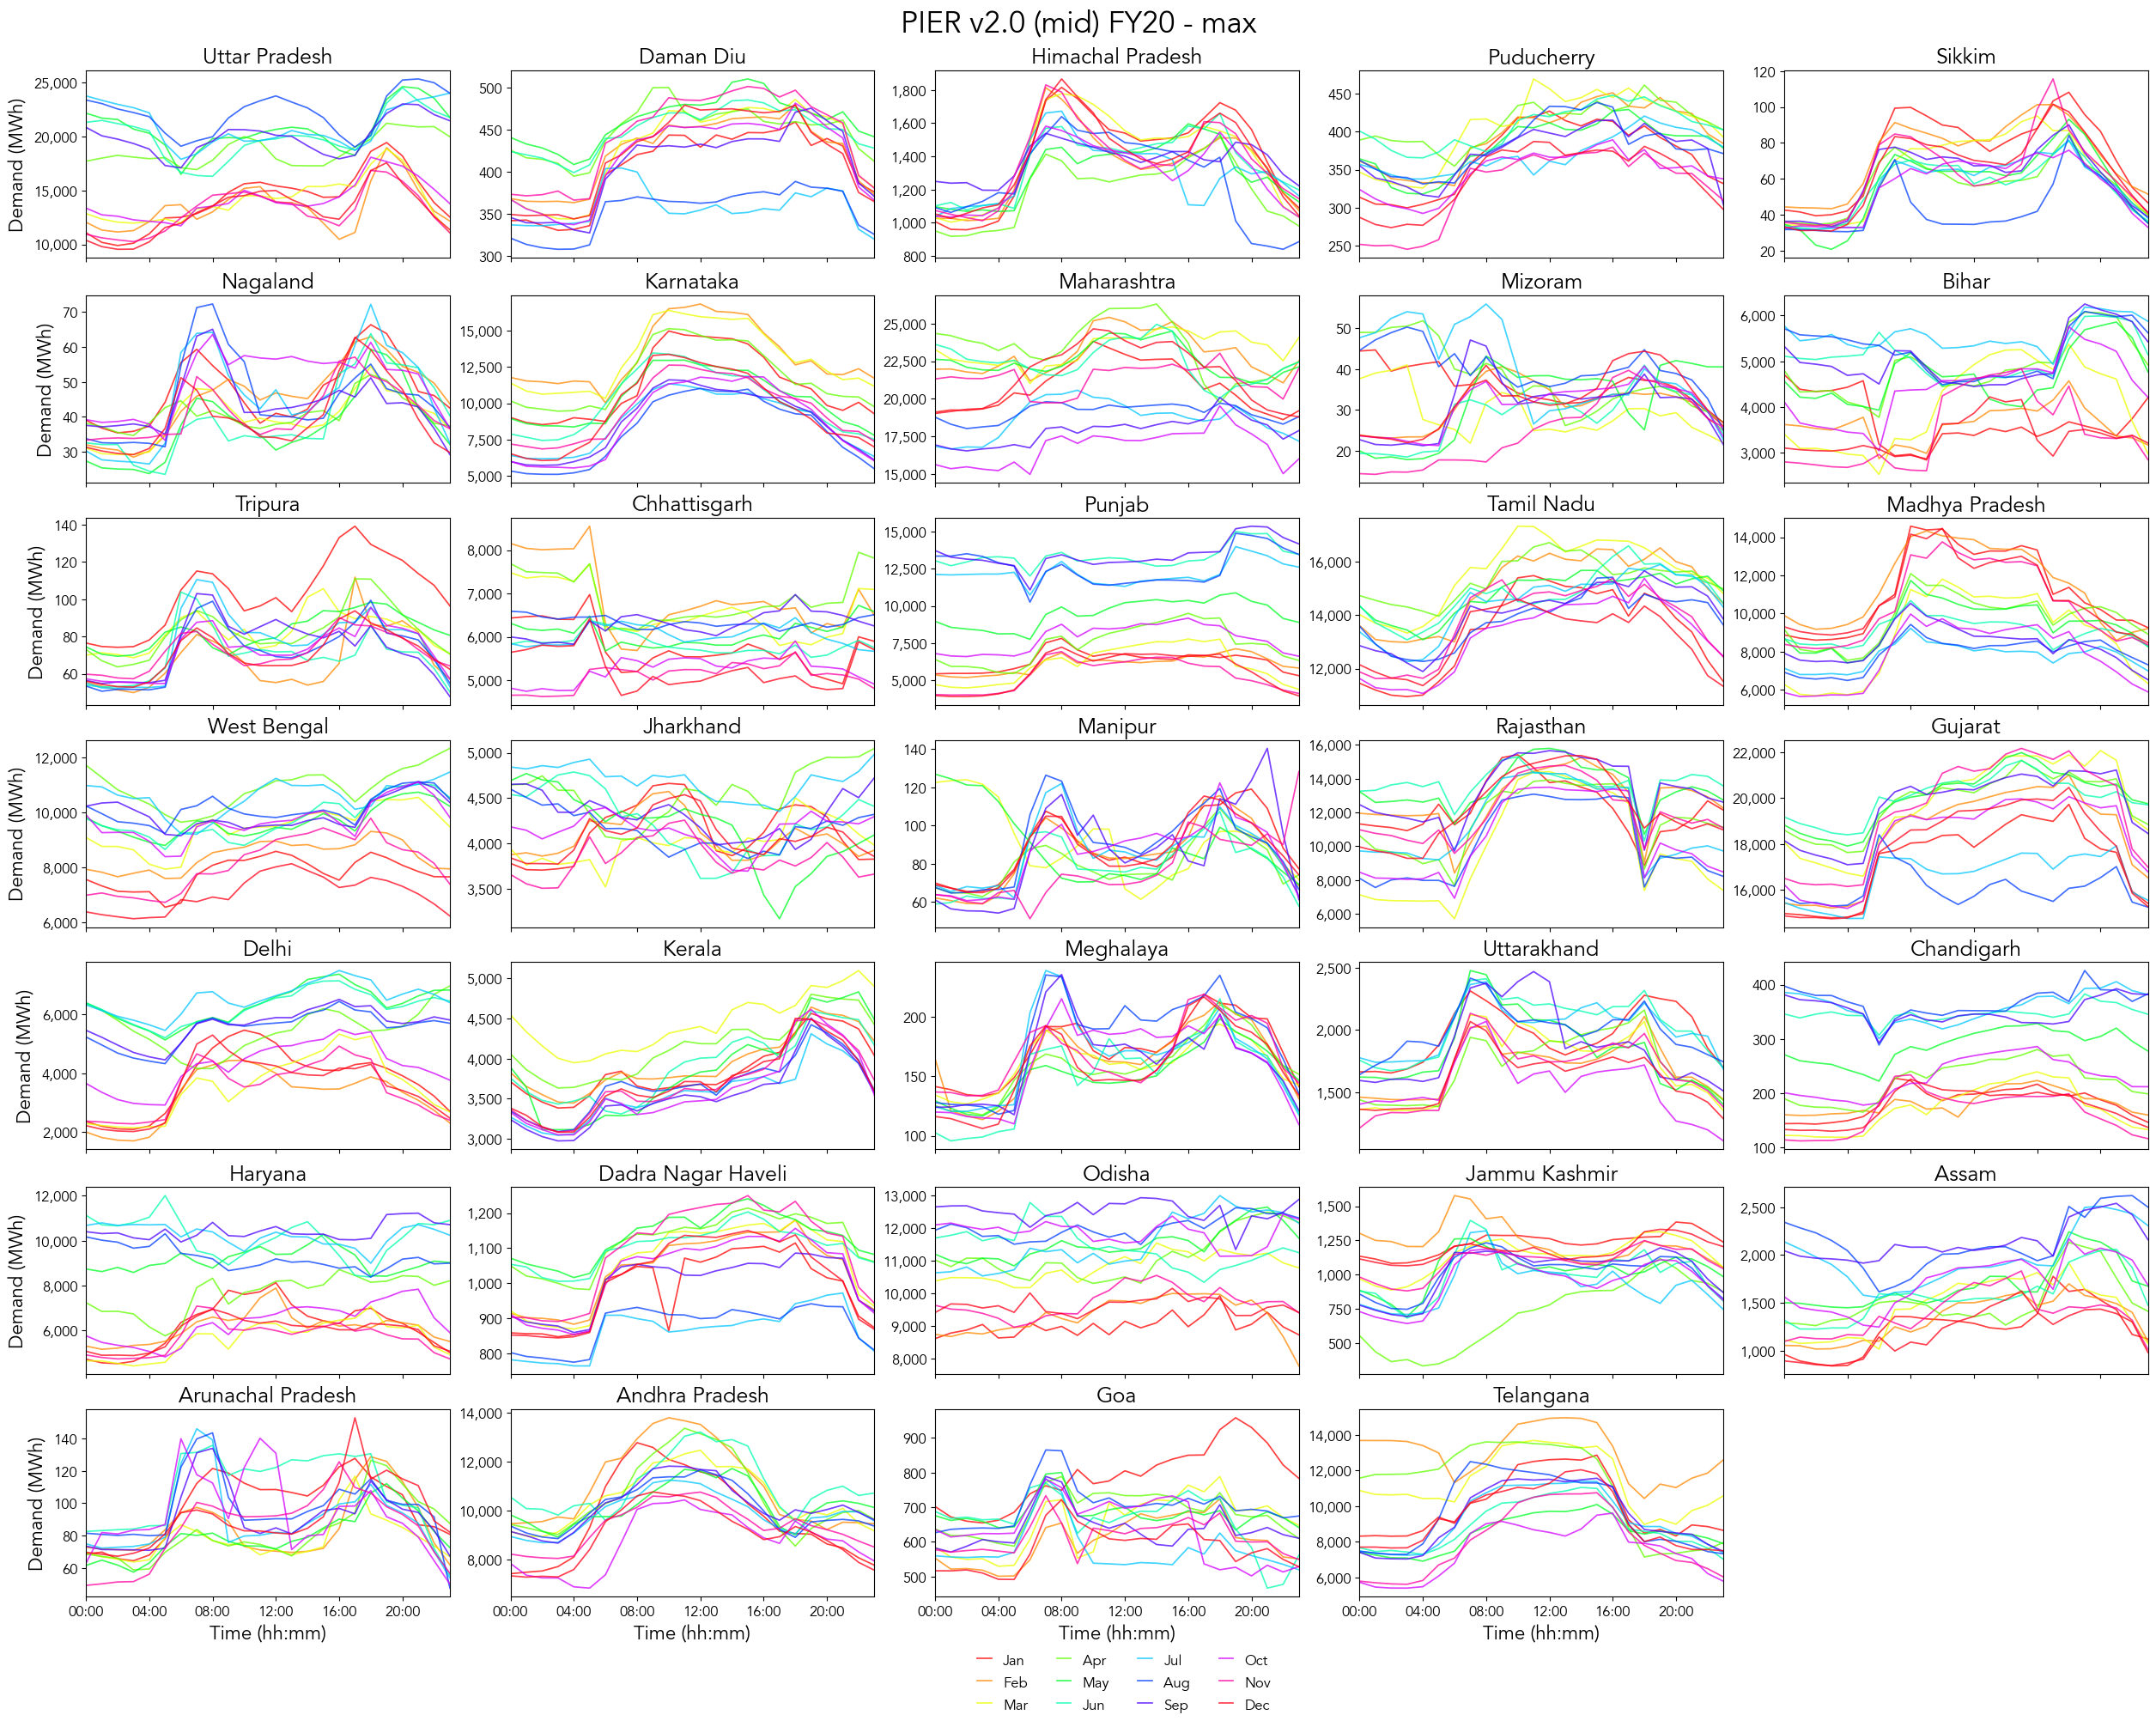

In [231]:
fy       = 2020
method   = 'max'
fig_name = 'pierv2_mid'
title    = 'PIER v2.0 (mid)'

# scenario = '2050-demand_forecast-transmission-PIERv2_2019_low'
scenario = '2050-demand_forecast-transmission-PIERv2_2019_mid'
# scenario = '2050-demand_forecast-transmission-PIERv2_2019_high'
# scenario = '2050-demand_forecast-transmission-ICED_2019_low'
# scenario = '2050-demand_forecast-transmission-ICED_2019_mid'
# scenario = '2050-demand_forecast-transmission-ICED_2019_high'

df_ = _load_demand_scenario(scenario, path_to_load)

month_ = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ix_ = []
for i in range(7):
    for j in range(5):
        ix_.append([i, j])
        
fig, axs_ = plt.subplots(7, 5, figsize = (25, 20), 
                               sharex  = True, 
                               layout  = 'constrained')

plt.suptitle(f'{title} FY{str(fy)[2:]} - {method}', fontsize = 25, weight = 'bold')

ylabel = 'Demand (MWh)'
xlabel = 'Time (hh:mm)'

x_ = np.linspace(0, 23, 24)

cmap = mpl.cm.get_cmap('hsv', 12)
for load_zone, j in zip(load_zones_, range(len(load_zones_))):

    for i in range(1, 13, 1):
        df_p_ = df_.loc[(df_['FY'] == fy) & (df_['Month'] == i), ['Day', 'Interval', load_zone]].reset_index(drop = True)
        df_pp_ = np.concatenate([df_p_.loc[df_p_['Day'] == d, load_zone].reset_index(drop = True).to_numpy()[:, np.newaxis] 
                                 for d in np.sort(df_p_['Day'].unique())], axis = 1)
        
        if method == 'avg': y_ = np.mean(df_pp_, axis = 1)
        if method == 'max': y_ = df_pp_[:, np.max(df_pp_, axis = 0).argmax()]
        if method == 'min': y_ = df_pp_[:, np.max(df_pp_, axis = 0).argmin()]

        axs_[ix_[j][0], ix_[j][1]].plot(x_, y_, 
                                        c     = cmap(i - 1), 
                                        label = month_[i - 1],
                                        lw    = 1.25,
                                        alpha = 0.75)
        
    axs_[ix_[j][0], ix_[j][1]].set_xticks(x_[::4], ["%02d:00" % x for x in x_][::4])

    if (j % 5 == 0):
        axs_[ix_[j][0], ix_[j][1]].set_ylabel(ylabel, fontsize = 16)

    if j >= 30:
        axs_[ix_[j][0], ix_[j][1]].set_xlabel(xlabel, fontsize = 16)
        
    axs_[ix_[j][0], ix_[j][1]].xaxis.set_tick_params(labelsize = 12)
    axs_[ix_[j][0], ix_[j][1]].yaxis.set_tick_params(labelsize = 12, left = True)
    
    axs_[ix_[j][0], ix_[j][1]].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axs_[ix_[j][0], ix_[j][1]].set_xlim(0, 23)
    axs_[ix_[j][0], ix_[j][1]].set_title(load_zone.replace("_", ' '), fontsize = 18)

axs_[ix_[-3][0], ix_[-3][1]].legend(loc     = (0.1, -0.65),
                                    frameon = False,
                                    ncol    = 4,
                                    prop    = {'size': 12})

fig.delaxes(axs_[ix_[-1][0], ix_[-1][1]])

plt.savefig(path_to_images + f'/{fig_name}-{method}-{fy}.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# System Level Demand Scenarios

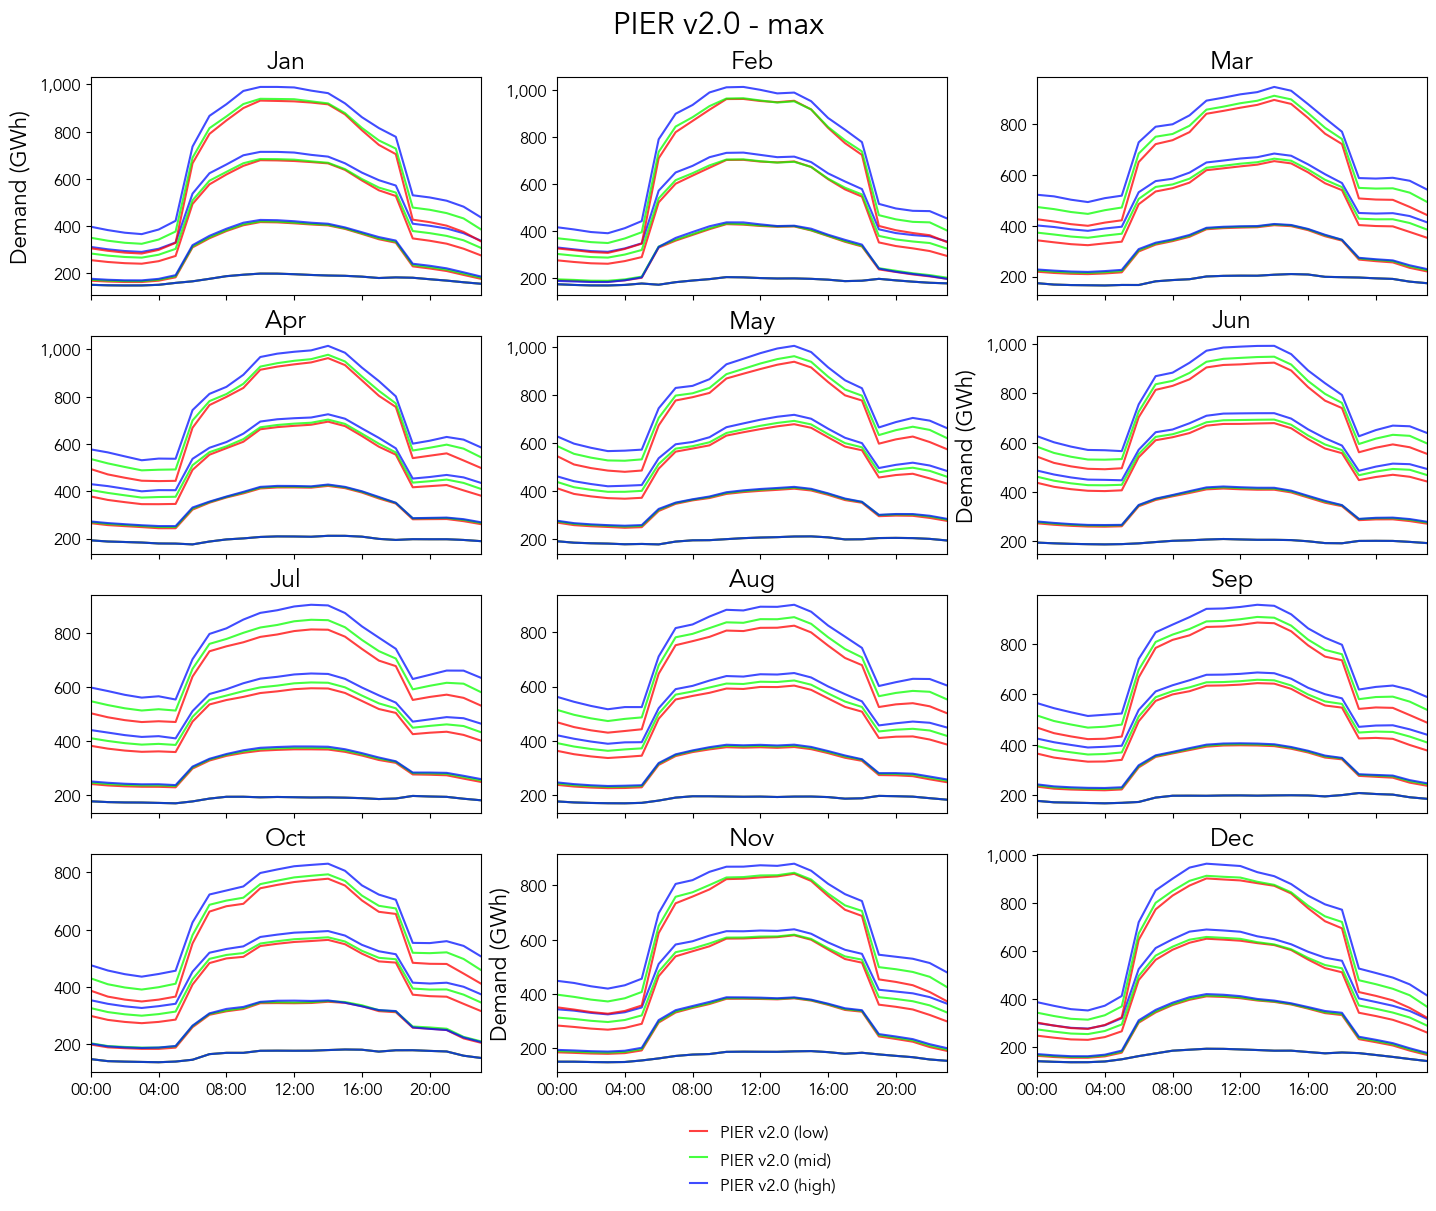

In [316]:
method   = 'max'
fig_name = 'pierv2'
title    = 'PIER v2.0'

scens_ = ['2050-demand_forecast-transmission-PIERv2_2019_low',
          '2050-demand_forecast-transmission-PIERv2_2019_mid',
          '2050-demand_forecast-transmission-PIERv2_2019_high']

scen_labels_ = ['PIER v2.0 (low)', 
                'PIER v2.0 (mid)', 
                'PIER v2.0 (high)']

df_ = _load_system_demand_scenarios(scens_, scen_labels_, path_to_load)

months_ = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fys_    = [2020, 2030, 2040, 2050]

ix_ = []
for i in range(4):
    for j in range(3):
        ix_.append([i, j])
        
fig, axs_ = plt.subplots(4, 3, figsize = (14.25, 12), 
                               sharex  = True, 
                               layout  = 'constrained')

plt.suptitle(f'{title} - {method}', fontsize = 22, weight = 'bold')

ylabel = 'Demand (GWh)'
xlabel = 'Time (hh:mm)'

x_ = np.linspace(0, 23, 24)

cmap = mpl.cm.get_cmap('hsv', 4)
for month, i in zip(months_, range(len(months_))):
    for fy, j in zip(fys_, range(len(fys_))):
        for scen_label, k in zip(scen_labels_, range(len(scen_labels_))):

            idx_  = (df_['FY'] == fy) & (df_['Month'] == i + 1) & (df_['scenario'] == scen_label)
            df_p_ = df_.loc[idx_, ['Day', 'Interval', 'India']].reset_index(drop = True)

            df_pp_ = np.concatenate([df_p_.loc[df_p_['Day'] == d, 'India'].reset_index(drop = True).to_numpy()[:, np.newaxis] 
                                     for d in np.sort(df_p_['Day'].unique())], axis = 1)

            if method == 'avg': y_ = np.mean(df_pp_, axis = 1)
            if method == 'max': y_ = df_pp_[:, np.max(df_pp_, axis = 0).argmax()]
            if method == 'min': y_ = df_pp_[:, np.min(df_pp_, axis = 0).argmin()]
            
            if fy == 2050:
                axs_[ix_[i][0], ix_[i][1]].plot(x_, y_/1e3, 
                                                c     = cmap(k), 
                                                label = scen_label,
                                                lw    = 1.5,
                                                alpha = 0.75)
            else:
                axs_[ix_[i][0], ix_[i][1]].plot(x_, y_/1e3, 
                                                c     = cmap(k), 
                                                lw    = 1.5,
                                                alpha = 0.75)

    if (i % 5 == 0):
        axs_[ix_[i][0], ix_[i][1]].set_ylabel(ylabel, fontsize = 16)

    if i >= 30:
        axs_[ix_[i][0], ix_[i][1]].set_xlabel(xlabel, fontsize = 16)
        
    axs_[ix_[i][0], ix_[i][1]].set_xticks(x_[::4], ["%02d:00" % x for x in x_][::4])
    axs_[ix_[i][0], ix_[i][1]].xaxis.set_tick_params(labelsize = 12)
    axs_[ix_[i][0], ix_[i][1]].yaxis.set_tick_params(labelsize = 12, left = True)
    axs_[ix_[i][0], ix_[i][1]].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axs_[ix_[i][0], ix_[i][1]].set_xlim(0, 23)
    axs_[ix_[i][0], ix_[i][1]].set_title(month, fontsize = 18)

axs_[ix_[-2][0], ix_[-2][1]].legend(loc     = (0.325, -0.59),
                                    frameon = False,
                                    ncol    = 1,
                                    prop    = {'size': 12})

plt.savefig(path_to_images + f'/{fig_name}-{method}.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [ ]:
method   = 'max'
fig_name = 'iced2019'
title    = 'ICED 2019'

scens_ = ['2050-demand_forecast-transmission-ICED_2019_low',
          '2050-demand_forecast-transmission-ICED_2019_mid',
          '2050-demand_forecast-transmission-ICED_2019_high']

scen_labels_ = ['ICED 2019 (low)', 
                'ICED 2019 (mid)', 
                'ICED 2019 (high)']

df_ = _load_system_demand_scenarios(scens_, scen_labels_, path_to_load)

months_ = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fys_    = [2020, 2030, 2040, 2050]

ix_ = []
for i in range(4):
    for j in range(3):
        ix_.append([i, j])
        
fig, axs_ = plt.subplots(4, 3, figsize = (14.25, 12), 
                               sharex  = True, 
                               layout  = 'constrained')

plt.suptitle(f'{title} - {method}', fontsize = 22, weight = 'bold')

ylabel = 'Demand (GWh)'
xlabel = 'Time (hh:mm)'

x_ = np.linspace(0, 23, 24)

cmap = mpl.cm.get_cmap('hsv', 4)
for month, i in zip(months_, range(len(months_))):
    for fy, j in zip(fys_, range(len(fys_))):
        for scen_label, k in zip(scen_labels_, range(len(scen_labels_))):

            idx_  = (df_['FY'] == fy) & (df_['Month'] == i + 1) & (df_['scenario'] == scen_label)
            df_p_ = df_.loc[idx_, ['Day', 'Interval', 'India']].reset_index(drop = True)

            df_pp_ = np.concatenate([df_p_.loc[df_p_['Day'] == d, 'India'].reset_index(drop = True).to_numpy()[:, np.newaxis] 
                                     for d in np.sort(df_p_['Day'].unique())], axis = 1)

            if method == 'avg': y_ = np.mean(df_pp_, axis = 1)
            if method == 'max': y_ = df_pp_[:, np.max(df_pp_, axis = 0).argmax()]
            if method == 'min': y_ = df_pp_[:, np.min(df_pp_, axis = 0).argmin()]
            
            if fy == 2050:
                axs_[ix_[i][0], ix_[i][1]].plot(x_, y_/1e3, 
                                                c     = cmap(k), 
                                                label = scen_label,
                                                lw    = 1.5,
                                                alpha = 0.75)
            else:
                axs_[ix_[i][0], ix_[i][1]].plot(x_, y_/1e3, 
                                                c     = cmap(k), 
                                                lw    = 1.5,
                                                alpha = 0.75)

    if (i % 3 == 0):
        axs_[ix_[i][0], ix_[i][1]].set_ylabel(ylabel, fontsize = 16)

    if i >= 9:
        axs_[ix_[i][0], ix_[i][1]].set_xlabel(xlabel, fontsize = 16)
        
    axs_[ix_[i][0], ix_[i][1]].set_xticks(x_[::4], ["%02d:00" % x for x in x_][::4])
    axs_[ix_[i][0], ix_[i][1]].xaxis.set_tick_params(labelsize = 12)
    axs_[ix_[i][0], ix_[i][1]].yaxis.set_tick_params(labelsize = 12, left = True)
    axs_[ix_[i][0], ix_[i][1]].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axs_[ix_[i][0], ix_[i][1]].set_xlim(0, 23)
    axs_[ix_[i][0], ix_[i][1]].set_title(month, fontsize = 18)

axs_[ix_[-2][0], ix_[-2][1]].legend(loc     = (0.325, -0.65),
                                    frameon = False,
                                    ncol    = 1,
                                    prop    = {'size': 12})

plt.savefig(path_to_images + f'/{fig_name}-{method}.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()